In [1]:
from layers.multi_head_attention import MultiHeadAttention

In [2]:
import numpy as np
import json
import os
import itertools
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, 
    # Flatten, 
    Conv2D, 
    MaxPool2D, 
    Reshape, 
    BatchNormalization, 
    # Lambda, 
    # Bidirectional, 
    # LSTM,
    # Concatenate,
    Dropout,
    LayerNormalization
    )
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow.keras.callbacks import TensorBoard
from tqdm import tqdm

In [3]:
# refer: https://keras.io/examples/vision/captcha_ocr/
class CTCLayer(layers.Layer):
    
    def __init__(self, name = None):
        super().__init__(name = name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost


    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)       
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [4]:
class CRNNOCR:
    
    def __init__(self, max_char_len, image_height, image_width):
        
        self.max_char_len = max_char_len
        self.image_height = image_height
        self.image_width = image_width
        
    
    def ctc_lambda_function(self, args):
        
        labels, y_pred, input_length, label_length = args
        
        return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
    
  
    def build_model(self):

        inputs = Input(shape = (self.image_width, self.image_height, 1), name = 'input_layer')
        labels = Input(shape = (None, ), name = 'label_input', dtype = 'float32')        
        
        convolution_layer_1 = Conv2D(
            filters = 64,
            kernel_size = (3, 3),
            strides = (1, 1),
            activation = 'relu',
            padding = 'same',
            name = 'convolution_layer_1_1'
            )(inputs)
            
        pooling_layer_1 = MaxPool2D(
            pool_size = (2, 2),
            strides = (2, 2),
            name = 'pooling_layer_1'
          )(convolution_layer_1)
                
            
            
        convolution_layer_2 = Conv2D(
            filters = 128, 
            kernel_size = (3, 3),
            strides = (1, 1),
            activation = 'relu',
            padding = 'same',
            name = 'convolution_layer_2_1'
            )(pooling_layer_1)
          
        pooling_layer_2 = MaxPool2D(
            pool_size = (2, 2),
            strides = (2, 2),
            name = 'pooling_layer_2_2'
          )(convolution_layer_2)
          
          
          
        convolution_layer_3_1 = Conv2D(
            filters = 256, 
            kernel_size = (3, 3),
            strides = (1, 1),
            activation = 'relu',
            padding = 'same',
            name = 'convolution_layer_3_1'          
            )(pooling_layer_2)
          
        convolution_layer_3_2 = Conv2D(
            filters = 256, 
            kernel_size = (3, 3),
            strides = (1, 1),
            activation = 'relu',
            name = 'convolution_layer_3_2',
            padding = 'same'
            )(convolution_layer_3_1)
          
        pooling_layer_3 = MaxPool2D(
            pool_size = (2, 2),
            strides = (1, 2),
            name = 'pooling_layer_3'
          )(convolution_layer_3_2)
          
          
          
        convolution_layer_4 = Conv2D(
            filters = 512, 
            kernel_size = (3, 3),
            strides = (1, 1),
            activation = 'relu',
            padding = 'same',
            name = 'convolution_layer_4_1'
            )(pooling_layer_3)    
          
        batch_normalization_layer_1 = BatchNormalization(name = 'batch_normalization_layer_1')(convolution_layer_4)
          
          
          
        convolution_layer_5 = Conv2D(
            filters = 512, 
            kernel_size = (3, 3),
            strides = (1, 1),
            activation = 'relu',
            padding = 'same',
            name = 'convolution_layer_5_1'
            )(batch_normalization_layer_1)
          
        batch_normalization_layer_2 = BatchNormalization(name = 'batch_normalization_layer_2')(convolution_layer_5)
          
        pooling_layer_4 = MaxPool2D(
              pool_size = (2, 2),
              strides = (2, 1),
              name = 'pooling_layer_4'
              )(batch_normalization_layer_2)
          
          
          
        convolution_layer_6 = Conv2D(
            filters = 512, 
            kernel_size = (2, 2),
            strides = (1, 1),
            activation = 'relu',
            padding = 'valid',
            name = 'convolution_layer_6_1'
            )(pooling_layer_4)
                  
        reshape_layer = Reshape((-1, 512), name = 'reshape_layer')(convolution_layer_6)
        
        multi_head_attention_layer = MultiHeadAttention(d_model = 512, num_heads = 8, name = 'multi_head_attention_layer')(
            {
                'query': reshape_layer,
                'key': reshape_layer,
                'value': reshape_layer
              }
            )
        
        
        dropout_layer_1 = Dropout(rate = 0.5, name = 'dropout_layer_1')(multi_head_attention_layer)
        residual_layer_1 = LayerNormalization(epsilon = 1e-6, name = 'layer_normalization_layer_1')(multi_head_attention_layer + dropout_layer_1)
        
        ffnn_1 = Dense(units = 4096, activation = 'relu', name = 'ffnn_layer_1')(residual_layer_1)
        ffnn_2 = Dense(units = 512, activation = 'relu', name = 'ffnn_layer_2')(ffnn_1)
        
        dropout_layer_2 = Dropout(rate = 0.5, name = 'dropout_layer_2')(ffnn_2)
        residual_layer_2 = LayerNormalization(epsilon = 1e-6, name = 'layer_normalization_layer_2')(residual_layer_1 + dropout_layer_2)
 
        outputs = Dense(units = self.max_char_len + 1, activation = 'softmax', name = 'classification_layer')(residual_layer_2)        
        ctc_loss = CTCLayer(name = 'ctc_loss')(labels, outputs)
        
        model = Model(inputs = [inputs, labels], outputs = ctc_loss)
        model.compile(optimizer = tf.keras.optimizers.Adam())
        
        return model

In [5]:
def split_data(images, labels, train_size = 0.9, shuffle = True):    
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid
    

In [6]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels = 1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm = [1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding = 'UTF-8'))
    # 7. Return a dict as our model is expecting two inputs
    return {'input_layer': img, 'label_input': label}

In [7]:
def encode_single_sample_for_predict(img_path):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels = 1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm = [1, 0, 2])
    
    return {'input_layer': img}

In [8]:
def decode_batch_predictions(pred, max_length):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = K.ctc_decode(pred, input_length = input_len, greedy = True)[0][0][
        :, :max_length
    ]
    
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
        output_text.append(res)
    
    output_text = output_text[0].replace('[UNK]', '')
    
    return output_text

In [9]:
### korean ###
korean_data_dir = Path('dataset/word')
korean_images = sorted(list(map(str, list(korean_data_dir.glob('*.png')))))

with open('dataset/printed_data_info (1).json', 'r', encoding = 'utf-8') as f:
    korean_data_info = json.loads(f.read())

korean_word_image_data_info = list(filter(lambda x: x['file_name'][:2] == '02', korean_data_info['images']))
korean_max_width = max(list(map(lambda x: x['width'], korean_word_image_data_info)))
korean_max_height = max(list(map(lambda x: x['height'], korean_word_image_data_info)))

korean_annotations = list(filter(lambda x: x['image_id'][:3] in ['022', '023', '024'], korean_data_info['annotations']))
existing_img_id_list = list(map(lambda x: x.split('/')[-1].split('.')[0], korean_images))

korean_annotations = list(filter(lambda x: x['image_id'] in existing_img_id_list, tqdm(korean_annotations)))
korean_word_image_data_info = list(filter(lambda x: x['id'] in existing_img_id_list, tqdm(korean_word_image_data_info)))

korean_labels = [img['text'] for img in tqdm(korean_annotations)]
korean_characters = set(char for label in korean_labels for char in label)

print('Number of images found: ', len(korean_word_image_data_info))
print('Number of labels found: ', len(korean_labels))
print('Number of unique characters: ', len(korean_characters))

100%|██████████| 262753/262753 [00:00<00:00, 1281591.26it/s]


Number of images found:  262753
Number of labels found:  262753
Number of unique characters:  974


In [10]:
### english ###
english_data_base_dir = Path('dataset/word_eng')
with open(os.path.join(english_data_base_dir, 'imlist.txt'), 'r') as f:
    english_images = f.read().split('\n')
english_images = list(map(lambda x: os.path.join(english_data_base_dir, x[2:]), english_images))

del(english_images[-1])

english_labels = [img.split(os.path.sep)[-1].split('.jpg')[0].split('/')[-1].split('_')[1] for img in tqdm(english_images)]
english_characters = set(char for label in tqdm(english_labels) for char in label)

print('Number of images found: ', len(english_images))
print('Number of labels found: ', len(english_labels))
print('Number of unique characters: ', len(english_characters))

100%|██████████| 8919273/8919273 [00:06<00:00, 1370840.14it/s]

Number of images found:  8919273
Number of labels found:  8919273
Number of unique characters:  62


In [11]:
### append ###
temp_labels = [korean_labels, english_labels]
temp_labels = list(itertools.chain(*temp_labels))
max_length = max([len(label) for label in temp_labels])
# padding
temp_labels = list(map(lambda x: ''.join([x, '~' * (max_length - len(x))]), temp_labels))

characters = [korean_characters, english_characters]
characters = list(itertools.chain(*characters))
characters.append(' ')

temp_images = [korean_images, english_images]
temp_images = list(itertools.chain(*temp_images))

In [12]:
images = []
labels = []

In [13]:
for idx, temp in tqdm(enumerate(zip(temp_images, temp_labels))):
    image, label = temp
    try:
        image_contents = tf.io.read_file(image)
        tf.image.decode_jpeg(image_contents)

        images.append(image)
        labels.append(label)
    except Exception as e:
        print(e)

525858it [05:43, 2073.68it/s]

Expected image (JPEG, PNG, or GIF), got empty file [Op:DecodeJpeg]


704715it [07:10, 1952.18it/s]

Expected image (JPEG, PNG, or GIF), got empty file [Op:DecodeJpeg]


1002958it [09:38, 2188.23it/s]

Invalid JPEG data or crop window, data size 512 [Op:DecodeJpeg]


1574541it [14:21, 1941.90it/s]

Invalid JPEG data or crop window, data size 1024 [Op:DecodeJpeg]


1622531it [14:44, 2016.68it/s]

Invalid JPEG data or crop window, data size 1024 [Op:DecodeJpeg]


1775359it [16:00, 2058.58it/s]

Invalid JPEG data or crop window, data size 512 [Op:DecodeJpeg]


2657537it [23:32, 1701.69it/s]

Invalid JPEG data or crop window, data size 1024 [Op:DecodeJpeg]


2858419it [25:13, 2032.05it/s]

Invalid JPEG data or crop window, data size 1024 [Op:DecodeJpeg]


3027085it [26:36, 2028.28it/s]

Expected image (JPEG, PNG, or GIF), got empty file [Op:DecodeJpeg]


3151546it [27:42, 2083.08it/s]

Expected image (JPEG, PNG, or GIF), got empty file [Op:DecodeJpeg]


3185762it [27:59, 2057.81it/s]

Invalid JPEG data or crop window, data size 512 [Op:DecodeJpeg]


3577324it [31:07, 2191.84it/s]

Invalid JPEG data or crop window, data size 512 [Op:DecodeJpeg]


3628074it [31:31, 2034.36it/s]

Invalid JPEG data or crop window, data size 512 [Op:DecodeJpeg]


3767214it [32:40, 2274.93it/s]

Expected image (JPEG, PNG, or GIF), got empty file [Op:DecodeJpeg]


4030523it [34:41, 2029.52it/s]

Invalid JPEG data or crop window, data size 1536 [Op:DecodeJpeg]


4129315it [35:28, 2004.70it/s]

Invalid JPEG data or crop window, data size 1024 [Op:DecodeJpeg]


4260695it [36:29, 1705.58it/s]

Invalid JPEG data or crop window, data size 1024 [Op:DecodeJpeg]


5219466it [43:43, 2452.09it/s]

Invalid JPEG data or crop window, data size 1024 [Op:DecodeJpeg]


6395075it [47:55, 5884.65it/s]

Invalid JPEG data or crop window, data size 1024 [Op:DecodeJpeg]


6451191it [48:05, 5973.98it/s]

Expected image (JPEG, PNG, or GIF), got empty file [Op:DecodeJpeg]


6475202it [48:09, 5980.25it/s]

Invalid JPEG data or crop window, data size 2048 [Op:DecodeJpeg]


6585444it [48:28, 5975.65it/s]

Invalid JPEG data or crop window, data size 512 [Op:DecodeJpeg]


7306089it [50:30, 6014.40it/s]

Invalid JPEG data or crop window, data size 1536 [Op:DecodeJpeg]


7398585it [50:46, 5712.27it/s]

Invalid JPEG data or crop window, data size 1536 [Op:DecodeJpeg]


7525793it [51:07, 5775.19it/s]

Invalid JPEG data or crop window, data size 3072 [Op:DecodeJpeg]


7695481it [51:35, 6122.84it/s]

Invalid JPEG data or crop window, data size 512 [Op:DecodeJpeg]


7888706it [52:07, 6253.99it/s]

Invalid JPEG data or crop window, data size 1024 [Op:DecodeJpeg]


8025796it [52:29, 6237.82it/s]

Invalid JPEG data or crop window, data size 1024 [Op:DecodeJpeg]


8074802it [52:37, 6029.78it/s]

Expected image (JPEG, PNG, or GIF), got empty file [Op:DecodeJpeg]


8354357it [53:22, 6161.50it/s]

Invalid JPEG data or crop window, data size 512 [Op:DecodeJpeg]


8385222it [53:26, 6051.69it/s]

Invalid JPEG data or crop window, data size 3072 [Op:DecodeJpeg]


8650013it [54:09, 6174.33it/s]

Expected image (JPEG, PNG, or GIF), got empty file [Op:DecodeJpeg]


9182026it [55:35, 2752.86it/s]


In [14]:
len(labels)

9181994

In [15]:
data_map = dict(zip(images, labels_without_padding))
with open('data_map.json', 'w', encoding = 'utf-8') as f:
    f.write(str(data_map))

In [16]:
print(f'max_height: {korean_max_height}')
print(f'max_width: {korean_max_width}')

max_height: 150
max_width: 612


In [17]:
downsample_factor = 4 
BATCH_SIZE = 192
IMAGE_HEIGHT = korean_max_height
IMAGE_WIDTH = 650

In [18]:
# preprocessing
char_to_num = StringLookup(
    vocabulary = list(characters), 
    num_oov_indices = 0
)

num_to_char = StringLookup(
    vocabulary = char_to_num.get_vocabulary(), 
    mask_token = None, 
    invert = True
)

In [19]:
labels_without_padding = list(map(lambda x: x.replace(' ', ''), labels))

In [20]:
labels = list(map(lambda x: ''.join([x, '#' * (max_length - len(x))]), labels_without_padding))

In [21]:
# split data
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

# tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls = tf.data.experimental.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls = tf.data.experimental.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
)

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 53685 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 53685 missing from current font.
  font.set_text(s, 

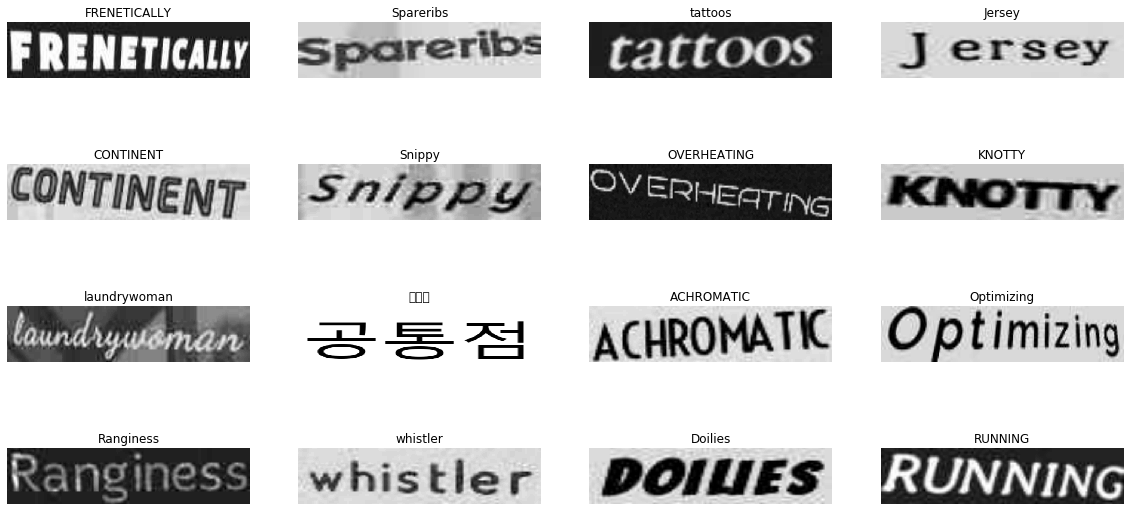

In [22]:
_, ax = plt.subplots(4, 4, figsize = (20, 10))
for batch in train_dataset.take(1):
    temp_images = batch['input_layer']
    temp_labels = batch['label_input']
    for i in range(16):
        img = (temp_images[i] * 255).numpy().astype('uint8')
        label = tf.strings.reduce_join(num_to_char(temp_labels[i][temp_labels[i] != 1037])).numpy().decode('utf-8')
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap = 'gray')
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis('off')
plt.show()

In [23]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [24]:
EPOCHS = 1

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 1,
    restore_best_weights = True
    )

tensorboard = TensorBoard(
    log_dir = 'log'
)



with strategy.scope():
    model = CRNNOCR(len(characters), IMAGE_HEIGHT, IMAGE_WIDTH).build_model()
    model.summary()


    history = model.fit(
        train_dataset,
        validation_data = validation_dataset,
        epochs = EPOCHS,
        callbacks = [early_stopping, tensorboard]
        )

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 650, 150, 1) 0                                            
__________________________________________________________________________________________________
convolution_layer_1_1 (Conv2D)  (None, 650, 150, 64) 640         input_layer[0][0]                
__________________________________________________________________________________________________
pooling_layer_1 (MaxPooling2D)  (None, 325, 75, 64)  0           convolution_layer_1_1[0][0]      
__________________________________________________________________________________________________
convolution_layer_2_1 (Conv2D)  (None, 325, 75, 128) 73856       pooling_layer_1[0][0]            
______________________________________________________________________________________

In [25]:
model.save_weights('model/ocr')

In [26]:
prediction_model = Model(
    model.get_layer(name = 'input_layer').input,
    model.get_layer(name = 'classification_layer').output
    )

In [27]:
test_image_path = list(Path('samples').glob('*.png'))

In [28]:
test_images = sorted(list(map(str, test_image_path)))

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)


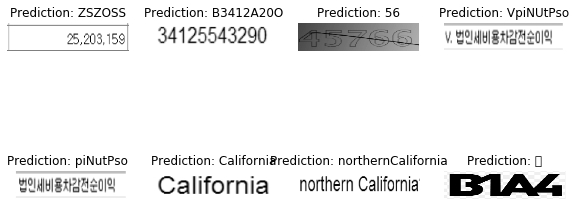

In [29]:
_, ax = plt.subplots(2, 4, figsize = (10, 5))
for i in range(len(test_images)):
    
    test_image = tf.data.Dataset.from_tensor_slices([test_images[i]]).take(1)
    test_image = (
        test_image.map(
            encode_single_sample_for_predict, num_parallel_calls = tf.data.experimental.AUTOTUNE
            )
        .batch(1)
        .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
        )
    
    pred = prediction_model.predict(test_image)
    predicted_label = decode_batch_predictions(pred, 25)
    
    img = (list(test_image)[0]['input_layer'][0, :, :, 0] * 255).numpy().astype('uint8')

    ax[i // 4, i % 4].imshow(img.T, cmap = 'gray')
    ax[i // 4, i % 4].set_title(f'Prediction: {predicted_label}')
    ax[i // 4, i % 4].axis('off')
    
plt.show()